In [2]:
import copy
from types import SimpleNamespace

import vrplib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd

from alns import ALNS
from alns.accept import RecordToRecordTravel
from alns.select import RouletteWheel
from alns.stop import MaxIterations

In [3]:
%matplotlib inline
SEED = 1234

# Capacitated Vehicle Routing Problem with Time Windows
Based on ALNS example of CVRP.

NOTE: needs implementation of pick-up and drop-off of customers

## Ideas for improvement

-   Change from native lists to numpy arrays
-   Delayed start

## Data
Description of datasets and BKS can be found here:

http://w.cba.neu.edu/~msolomon/problems.htm

In [4]:
data = vrplib.read_instance("./data/r1/r102.txt", instance_format="solomon")

Depot location is the first location in node_coord, beacuse demand = 0

In [5]:
data['dimension'] = len(data['demand'])
print(data.keys())

dict_keys(['name', 'vehicles', 'capacity', 'node_coord', 'demand', 'time_window', 'service_time', 'edge_weight', 'dimension'])


In [6]:
print(data['demand'])
print(type(data['demand']))

[ 0 10  7 13 19 26  3  5  9 16 16 12 19 23 20  8 19  2 12 17  9 11 18 29
  3  6 17 16 16  9 21 27 23 11 14  8  5  8 16 31  9  5  5  7 18 16  1 27
 36 30 13 10  9 14 18  2  6  7 18 28  3 13 19 10  9 20 25 25 36  6  5 15
 25  9  8 18 13 14  3 23  6 26 16 11  7 41 35 26  9 15  3  1  2 22 27 20
 11 12 10  9 17]
<class 'numpy.ndarray'>


In [5]:
print(data['edge_weight'])
print(type(data["edge_weight"]))

[[ 0.         15.23154621 18.         ... 21.26029163 17.49285568
  24.04163056]
 [15.23154621  0.         32.55764119 ... 35.60898763 31.144823
  38.60051813]
 [18.         32.55764119  0.         ... 16.4924225  17.49285568
  17.02938637]
 ...
 [21.26029163 35.60898763 16.4924225  ...  0.          5.09901951
   3.16227766]
 [17.49285568 31.144823   17.49285568 ...  5.09901951  0.
   8.24621125]
 [24.04163056 38.60051813 17.02938637 ...  3.16227766  8.24621125
   0.        ]]
<class 'numpy.ndarray'>


In [6]:
def plot_data(data, name="VRPTW Data"):
    """
    Plot the routes of the passed-in solution.
    """
    fig, ax = plt.subplots(figsize=(12, 10))

    ax.plot(data['node_coord'][1:, 0], data['node_coord'][1:, 1], 'o', label="Customers")
    ax.plot(
        data["node_coord"][0, 0], data["node_coord"][0, 1], "X", label="Depot"
    )

    ax.set_title(f"{name}")
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")
    ax.legend(frameon=False, ncol=3)


def plot_solution(solution, name="CVRP solution"):
    """
    Plot the routes of the passed-in solution.
    """
    fig, ax = plt.subplots(figsize=(12, 10))
    cmap = matplotlib.cm.rainbow(np.linspace(0, 1, len(solution.routes)))

    for idx, route in enumerate(solution.routes):
        ax.plot(
            [data["node_coord"][loc][0] for loc in [0] + route + [0]],
            [data["node_coord"][loc][1] for loc in [0] + route + [0]],
            color=cmap[idx],
            marker=".",
        )

    # Plot the depot
    kwargs = dict(label="Depot", zorder=3, marker="*", s=750)
    ax.scatter(*data["node_coord"][0], c="tab:red", **kwargs)

    ax.set_title(f"{name}\n Total distance: {solution.cost}")
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")
    ax.legend(frameon=False, ncol=3)

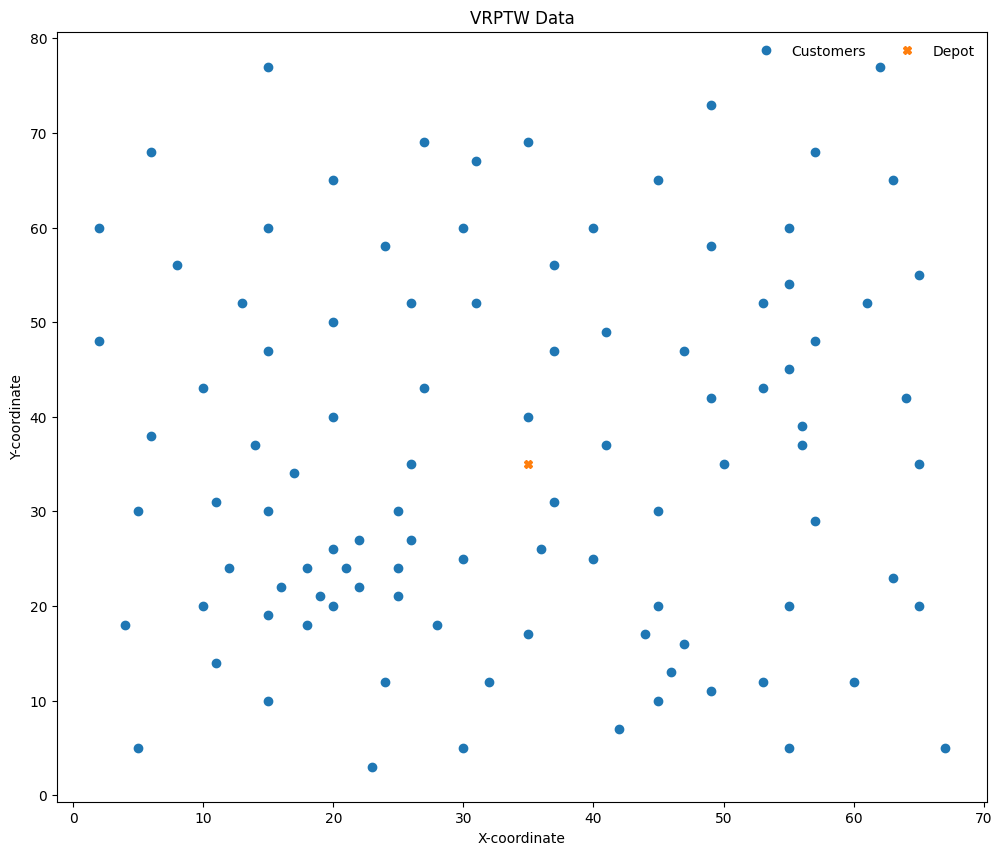

In [7]:
plot_data(data)

## Solution state

In [8]:
class CvrptwState:
    """
    Solution state for CVRPTW. It has two data members, routes and unassigned.
    Routes is a list of list of integers, where each inner list corresponds to
    a single route denoting the sequence of customers to be visited. A route
    does not contain the start and end depot. Times is a list of list, containing
    the planned arrival times for each customer in the routes. The outer list
    corresponds to the routes, and the inner list corresponds to the customers of
    the route. Unassigned is a list of integers, each integer representing an 
    unassigned customer.
    """

    def __init__(self, routes, times, unassigned=None):
        self.routes = routes
        self.times = times     # planned arrival times for each customer
        self.unassigned = unassigned if unassigned is not None else []

    def copy(self):
        return CvrptwState(
            copy.deepcopy(self.routes), self.times.copy(), self.unassigned.copy()
        )

    def objective(self):
        """
        Computes the total route costs.
        """
        return sum(route_cost(route) for route in self.routes)

    @property
    def cost(self):
        """
        Alias for objective method. Used for plotting.
        """
        return self.objective()

    def find_route(self, customer):
        """
        Return the route that contains the passed-in customer.
        """
        for route in self.routes:
            if customer in route:
                return route

        raise ValueError(f"Solution does not contain customer {customer}.")
    
    def find_index_in_route(self, customer, route):
        """
        Return the index of the customer in the route.
        """
        if customer in route:
            return route.index(customer)

        raise ValueError(f"Given route does not contain customer {customer}.")

    def update_times(self):
        """
        Update the arrival times of each customer in the routes.
        """
        for idx, route in enumerate(self.routes):
            self.times[idx] = self.evaluate_times_of_route(route)

    def evaluate_times_of_route(self, route):
        """
        Update the arrival times of each customer in a given route.
        """
        timings = [0]
        current_position = 0
        for customer in route:
            movement_time = data["edge_weight"][current_position][customer]
            # add the service time of the last customer
            timings.append(timings[-1] + data["service_time"][current_position])
            # add the movement time to reach next customer
            timings[-1] = float(timings[-1] + movement_time)

        return timings

    def print_state_dimensions(self):
        print(f"Number of routes: {len(self.routes)}")
        print(f"Length of routes: {[len(route) for route in self.routes]}")
        print(f"Dimensions of times: {[len(route) for route in self.times]}")
        print(f"Number of unassigned customers: {len(self.unassigned)}")
        print(f"Number of customers in routes: {sum(len(route) for route in self.routes)}")


# NOTE: maybe add time influence on cost of solution ?
def route_cost(route):
    distances = data["edge_weight"]
    tour = [0] + route + [0]

    return sum(
        distances[tour[idx]][tour[idx + 1]] for idx in range(len(tour) - 1)
    )

In [9]:
def get_customer_info(data, state: CvrptwState, idx):
    """
    Get the customer information for the passed-in index.
    """
    route = state.find_route(idx)
    index_in_route = state.find_index_in_route(idx, route)
    route_index = state.routes.index(route)
    print(f"index_in_route: {index_in_route}")
    print(f"route: {route}")
    planned_service_time = state.times[route_index][index_in_route]

    dict = {
        "index": idx,
        "coords": data["node_coord"][idx],
        "demand": data["demand"][idx].item(),
        "ready time": data["time_window"][idx, 0].item(),
        "due time": data["time_window"][idx, 1].item(),
        "service_time": data["service_time"][idx].item(),
        "route": route,
        "planned service time": planned_service_time,
    }

    return dict

## Destroy operators

Destroy operators break parts of a solution down, leaving an incomplete state. This is the first part of each iteration of the ALNS meta-heuristic; the incomplete solution is subsequently repaired by any one repair operator. We will consider one destroy operator: **random removal**. We will also use a separate parameter, the degree of destruction, to control the extent of the damage done to a solution in each step.

In [10]:
degree_of_destruction = 0.05
customers_to_remove = int((data["dimension"] - 1) * degree_of_destruction)
print(f"Removing {customers_to_remove} customers.")

Removing 5 customers.


In [11]:
def random_removal(state, rng):
    """
    Removes a number of randomly selected customers from the passed-in solution.
    """
    destroyed = state.copy()

    for customer in rng.choice(
        range(1, data["dimension"]), customers_to_remove, replace=False
    ):
        destroyed.unassigned.append(customer)
        route = destroyed.find_route(customer)
        route.remove(customer)

    # NOTE: now evaluate the time of the modified routes and return them
    destroyed.update_times()

    return remove_empty_routes(destroyed)


def remove_empty_routes(state):
    """
    Remove empty routes and timings after applying the destroy operator.
    """
    routes_idx_to_remove = [idx for idx, route in enumerate(state.routes) if len(route) == 0]
    state.routes = [route for idx, route in enumerate(state.routes) if idx not in routes_idx_to_remove] 
    state.times = [timing for idx, timing in enumerate(state.times) if idx not in routes_idx_to_remove]
    state.times = [timing for idx, timing in enumerate(state.times) if len(state.routes[idx]) != 0]
    return state

## Repair operators
We implement a simple, **greedy repair** strategy. It iterates over the set of unassigned customers and finds the best route and index to insert to, i.e., with the least increase in cost. Time window constraints are implemented as follows in the **greedy repair**:

1)  Within the set of unvisited nodes, first find those nodes that can be visited within the node's time window from the current end of each existing route
2)  Add the node that is nearest to the end of some route to that route
3)  If no unvisited nodes can be visited on time, make a new route just for that node

In [29]:
def greedy_repair(state, rng):
    """
    Inserts the unassigned customers in the best route. If there are no
    feasible insertions, then a new route is created. Only checks capacity constraints.
    """
    rng.shuffle(state.unassigned)

    while len(state.unassigned) != 0:
        customer = state.unassigned.pop()
        route, idx = best_insert(customer, state)

        if route is not None:
            route.insert(idx, customer.item())
            state.update_times()
            # DEBUG
            # print(f"\nCustomer {customer} inserted in route {route} at position {idx}.")
            # print(f"Planned service time for customer {customer}: {state.times[state.routes.index(route)][idx]}")
            # print(f"Requested time window: {data['time_window'][customer]}\n")
        else:
            # Initialize a new route and corresponding timings
            state.routes.append([customer.item()])
            state.times.append([0])
            state.update_times()    # NOTE: maybe not needed 

    return state

def greedy_repair_tw(state, rng):
    """
    Inserts the unassigned customers in the best route. If there are no
    feasible insertions, then a new route is created. Check capacity and time window constraints.
    """
    rng.shuffle(state.unassigned)

    while len(state.unassigned) != 0:
        customer = state.unassigned.pop()
        route, idx = best_insert_tw(customer, state)

        if route is not None:
            route.insert(idx, customer.item())
            state.update_times()
        else:
            # Initialize a new route and corresponding timings
            state.routes.append([customer.item()])
            state.times.append([0])
            state.update_times()  # NOTE: maybe not needed

    return state


def best_insert(customer, state):
    """
    Finds the best feasible route and insertion idx for the customer.
    Return (None, None) if no feasible route insertions are found.
    Only checks capacity constraints.
    """
    best_cost, best_route, best_idx = None, None, None

    for route_number, route in enumerate(state.routes):
        for idx in range(len(route) + 1):
            # DEBUG
            # print(f"In best_insert: route_number = {route_number}, idx = {idx}")
            if can_insert(customer, route_number, idx, state):
                cost = insert_cost(customer, route, idx)             

                if best_cost is None or cost < best_cost:
                    best_cost, best_route, best_idx = cost, route, idx

    return best_route, best_idx


def best_insert_tw(customer, state):
    """
    Finds the best feasible route and insertion idx for the customer.
    Return (None, None) if no feasible route insertions are found.
    Checks both capacity and time window constraints.
    """
    best_cost, best_route, best_idx = None, None, None

    for route_number, route in enumerate(state.routes):
        for idx in range(len(route) + 1):
            # DEBUG
            # print(f"In best_insert: route_number = {route_number}, idx = {idx}")
            if can_insert_tw(customer, route_number, idx, state):
                cost = insert_cost(customer, route, idx)

                if best_cost is None or cost < best_cost:
                    best_cost, best_route, best_idx = cost, route, idx

    return best_route, best_idx


# NOTE: I think performance can be improved by changing this function
def can_insert(customer, route_number, idx, state):
    """
    Checks if inserting customer in route 'route_number' at position 'idx' does not exceed vehicle capacity.
    """

    route = state.routes[route_number]
    # Capacity check

    #DEBUG
    print("DEBUG:")
    print(type(data['demand']))
    print(type([route]))
    print(type([customer]))
    total = data["demand"][route].sum() + data["demand"][customer]
    if total > data["capacity"]:
        return False      
    return True


# NOTE: I think performance can be improved by changing this function
def can_insert_tw(customer, route_number, idx, state):
    """
    Checks if inserting customer in route 'route_number' at position 'idx' does not exceed vehicle capacity and time window constraints.
    """

    route = state.routes[route_number]
    # Capacity check
    total = data["demand"][route].sum() + data["demand"][customer]
    if total > data["capacity"]:
        return False
    # Time window check
    if time_window_check(state.times[route_number][idx - 1], route[idx - 1], customer):
        return route_time_window_check(route, state.times[route_number])


def route_time_window_check(route, times):
    """
    Check if the route satisfies time-window constraints.
    """
    for idx, customer in enumerate(route):
        if times[idx] > data["time_window"][customer][1]:
            return False

    return True

# NOTE: this is a terrible check.
# It will accept any customer whose time window is after the calculated arrival time,
# even if the vehicle is early.
# Is the vehicle allowd to be early?
def time_window_check(prev_customer_time, prev_customer, candidate_customer):
    """
    Check if the candidate customer satisfies time-window constraints.
    """

    return prev_customer_time + data["service_time"][prev_customer] + data[
        "edge_weight"][prev_customer][candidate_customer] <= data["time_window"][candidate_customer][1]

def insert_cost(customer, route, idx):
    """
    Computes the insertion cost for inserting customer in route at idx.
    """
    dist = data["edge_weight"]
    pred = 0 if idx == 0 else route[idx - 1]
    succ = 0 if idx == len(route) else route[idx]

    # Increase in cost of adding customer, minus cost of removing old edge
    return dist[pred][customer] + dist[customer][succ] - dist[pred][succ]

## Initial solution
We need an initial solution that is going to be destroyed and repaired by the ALNS heuristic. To this end, we use a simple *nearest neighbor (NN)* heuristic. NN starts with an empty solution and iteratively adds the nearest customer to the routes. If there are no routes available, then a new route is created.

In [13]:
def neighbors(customer):
    """
    Return the nearest neighbors of the customer, excluding the depot.
    """
    locations = np.argsort(data["edge_weight"][customer])
    return locations[locations != 0]


def nearest_neighbor_tw():
    """
    Build a solution by iteratively constructing routes, where the nearest
    time-window compatible customer is added until the route has met the 
    vehicle capacity limit.
    """
    routes = []
    full_schedule = []
    unvisited = set(range(1, data["dimension"]))

    while unvisited:
        route = [0]  # Start at the depot
        route_schedule = [0]
        route_demands = 0

        while unvisited:
            # Add the nearest unvisited customer to the route till max capacity
            current = route[-1]
            nearest = [nb for nb in neighbors(current) if nb in unvisited][0]
            nearest = int(nearest)

            if route_demands + data["demand"][nearest] > data["capacity"]:
                break

            if not time_window_check(route_schedule[-1], current, nearest):
                break
            if not route_time_window_check(route, route_schedule):
                break

            route.append(nearest)

            route_schedule.append(
                data["edge_weight"][current][nearest].item()
                + data["service_time"][current].item()
            )

            unvisited.remove(nearest)
            route_demands += data["demand"][nearest]

        customers = route[1:]  # Remove the depot
        routes.append(customers)
        full_schedule.append(route_schedule)

    return CvrptwState(routes, full_schedule)

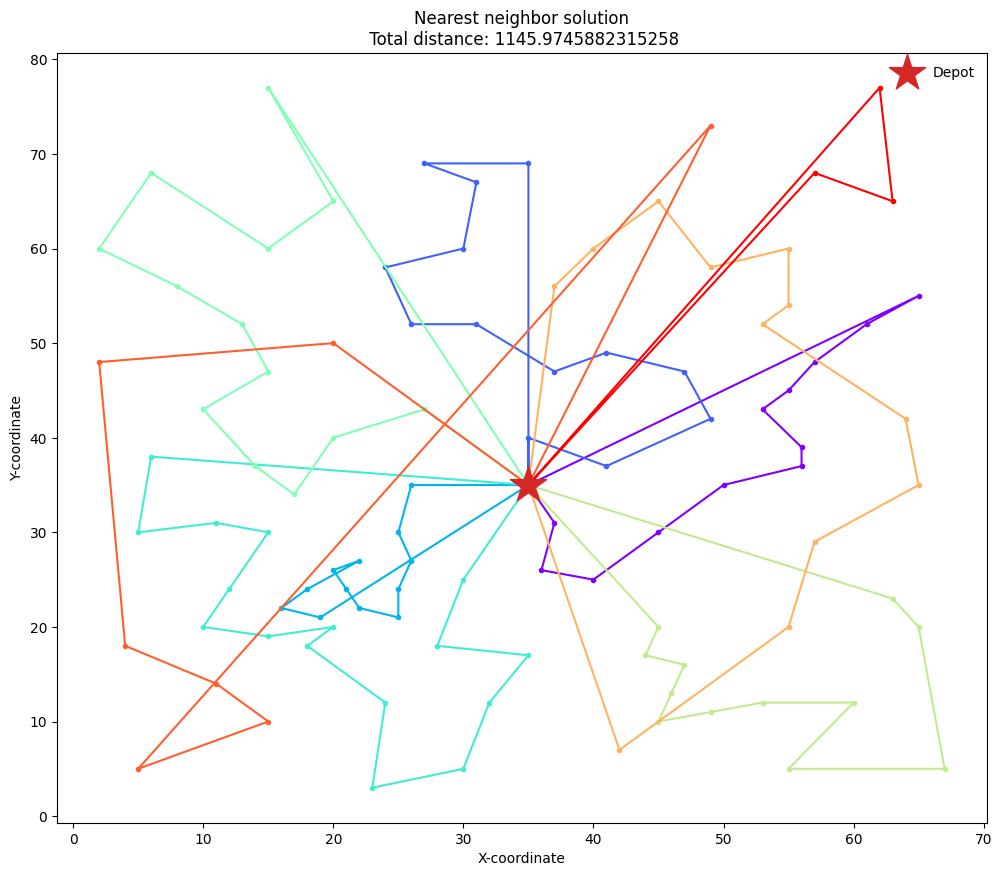

In [14]:
initial_solution = nearest_neighbor_tw()

plot_solution(initial_solution, "Nearest neighbor solution")

In [15]:
def verify_time_windows(state):
    """
    Counts the number of customers that are served late or early in the solution.
    """
    late, early, ontime = 0, 0, 0
    for customer in range(1, data["dimension"]):
        route = state.find_route(customer)
        idx = state.find_index_in_route(customer, route)
        arrival_time = state.times[state.routes.index(route)][idx]
        due_time = data["time_window"][customer][1]
        ready_time = data["time_window"][customer][0]
        if arrival_time > due_time:
            late += 1
        elif arrival_time < ready_time:
            early += 1
        elif arrival_time >= ready_time and arrival_time <= due_time:
            ontime += 1
    return late, early, ontime

late, early, ontime = verify_time_windows(initial_solution)
print(f"Late: {late}, Early: {early}, Ontime: {ontime}")

Late: 0, Early: 75, Ontime: 25


## Heuristic solution

Let's now construct our ALNS heuristic. Since we only have one destroy and repair operator, we do not actually use any adaptive operator selection -- but you can easily add more destroy and repair operators. 

In [16]:
alns = ALNS(rnd.default_rng(SEED))

alns.add_destroy_operator(random_removal)

alns.add_repair_operator(greedy_repair)

In [17]:
num_iterations = 5000
init = nearest_neighbor_tw()
select = RouletteWheel([25, 5, 1, 0], 0.8, 1, 1)
accept = RecordToRecordTravel.autofit(
    init.objective(), 0.02, 0, num_iterations
)
stop = MaxIterations(num_iterations)
result = alns.iterate(init, select, accept, stop)

In [18]:
solution = result.best_state
objective = solution.objective()
print(f"Best heuristic objective is {objective}.")

Best heuristic objective is 840.246356639989.


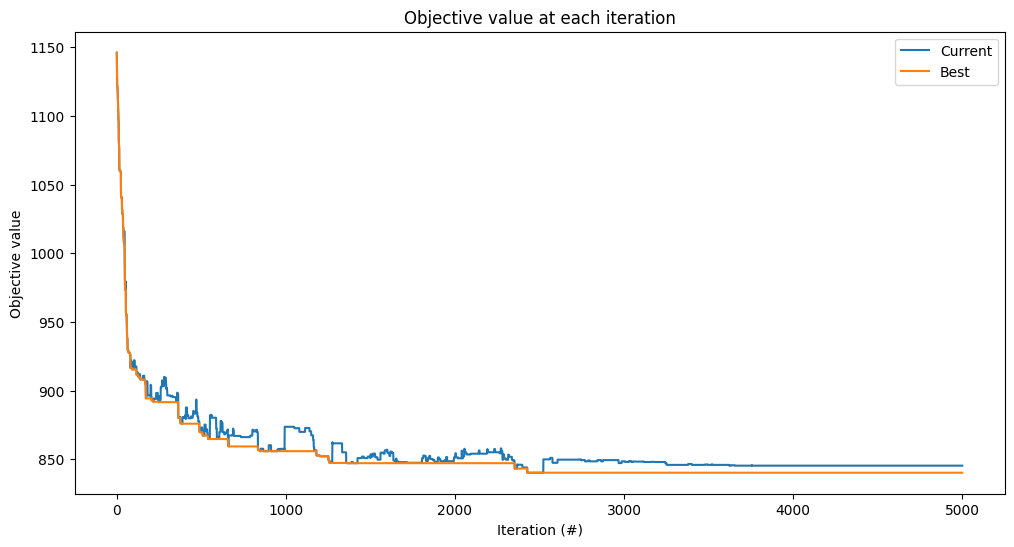

In [19]:
_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax)

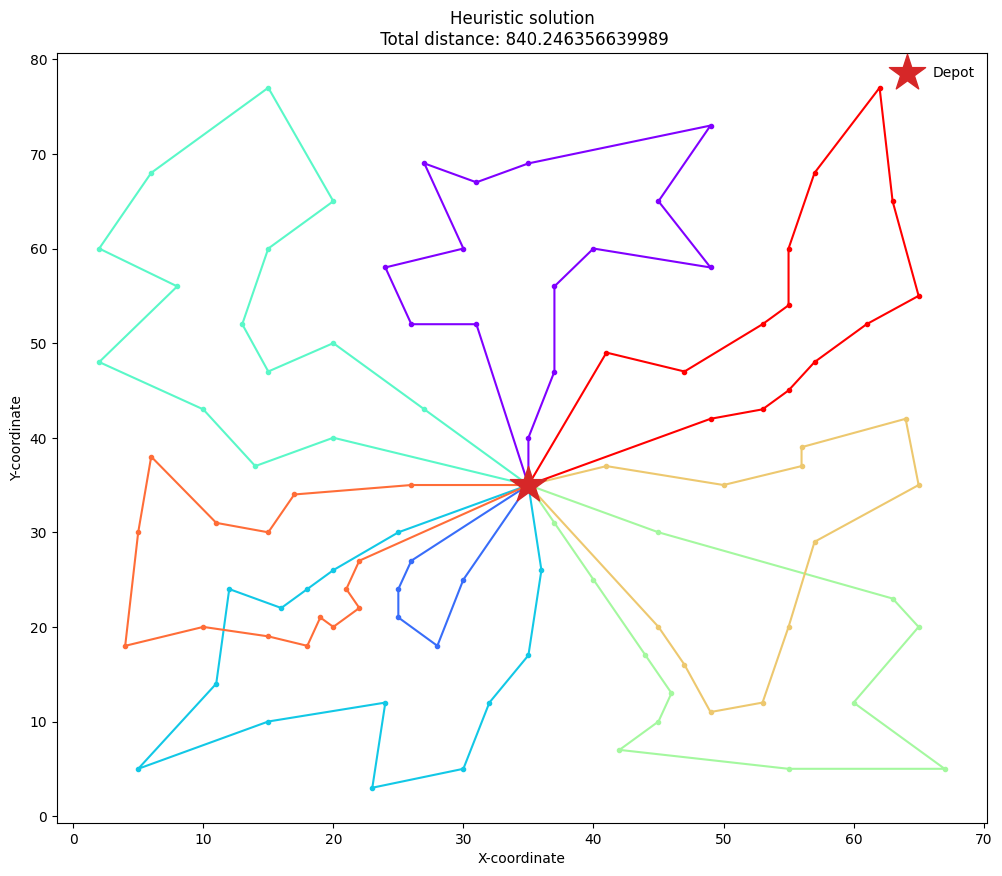

In [20]:
plot_solution(solution, "Heuristic solution")

In [21]:
alns = ALNS(rnd.default_rng(SEED))

alns.add_destroy_operator(random_removal)

alns.add_repair_operator(greedy_repair_tw)

In [22]:
num_iterations = 5000
init = nearest_neighbor_tw()
select = RouletteWheel([25, 5, 1, 0], 0.8, 1, 1)
accept = RecordToRecordTravel.autofit(
    init.objective(), 0.02, 0, num_iterations
)
stop = MaxIterations(num_iterations)
result = alns.iterate(init, select, accept, stop)

In [23]:
solution = result.best_state
objective = solution.objective()
print(f"Best heuristic objective is {objective}.")

Best heuristic objective is 1137.7978671741344.


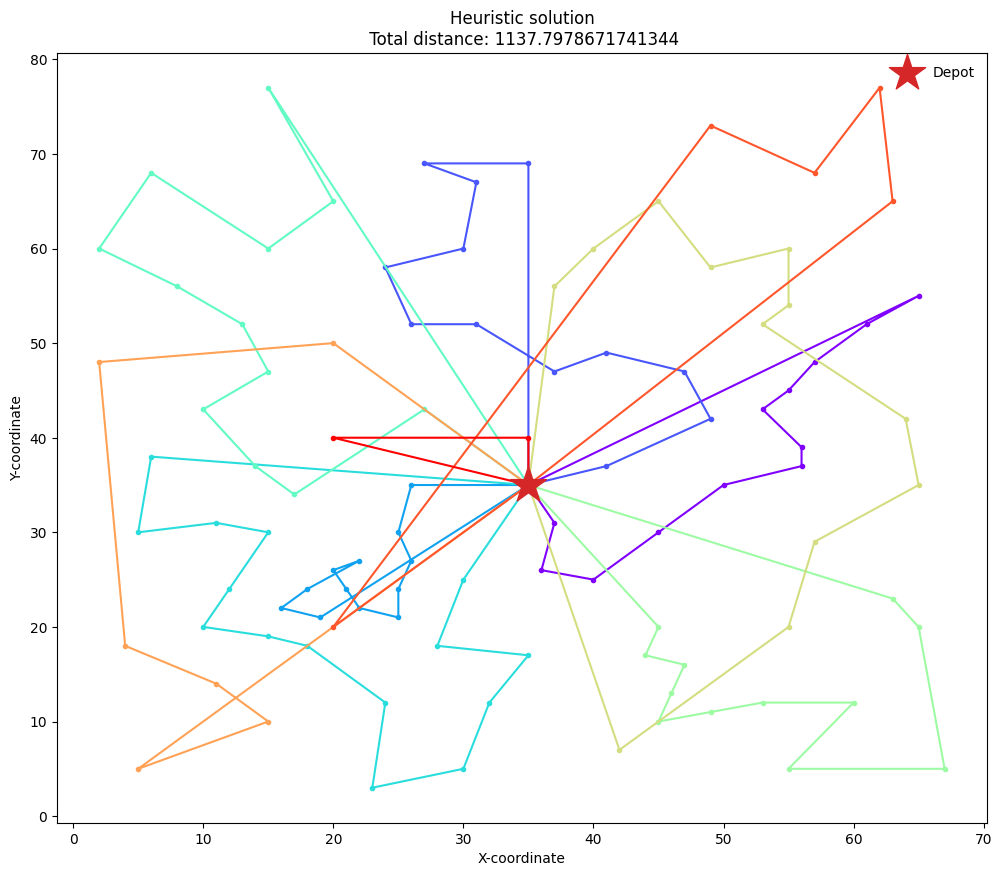

In [24]:
plot_solution(solution, "Heuristic solution")

## Verifying the time window constraints

In [25]:
late, early, ontime = verify_time_windows(solution)
print(f"Late: {late}, Early: {early}, Ontime: {ontime}")

Late: 38, Early: 32, Ontime: 30


In [26]:

# lates = []
# earlies = []
# ontimes = []

# for step in range(1000, 20000, 500):
#     result = alns.iterate(init, select, accept, MaxIterations(step))
#     solution = result.best_state
#     objective = solution.objective()
#     late, early, ontime = verify_time_windows(solution)
#     lates.append(late)
#     earlies.append(early)
#     ontimes.append(ontime)
#     print(f"Step: {step}, Objective: {objective}, Late: {late}, Early: {early}, Ontime: {ontime}")


NameError: name 'lates' is not defined

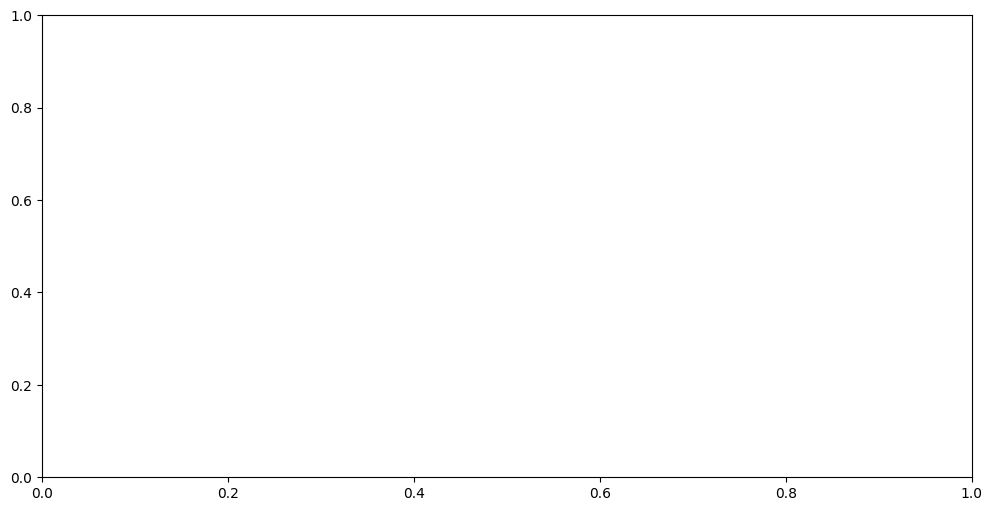

In [27]:
# fig, ax = plt.subplots(figsize=(12, 6))
# ax.plot(range(1000, 20000, 500), lates, label="Late", color="blue")
# ax.plot(range(1000, 20000, 500), earlies, label="Early", color="red")
# ax.plot(range(1000, 20000, 500), ontimes, label="Ontime", color="green")
# ax.set_xlabel("Iterations")
# ax.set_ylabel("Number of customers")
# ax.set_ylim(0, 100)
# ax.legend(frameon=False)
# plt.show()


In [28]:
easy_sol = nearest_neighbor_tw()

late, early, ontime = verify_time_windows(easy_sol)
print(f"Number of late customers: {late}")
print(f"Number of early customers: {early}")
print(f"Number of on-time customers: {ontime}")
print(f"Checksum of customers: {late + early + ontime}")

Number of late customers: 0
Number of early customers: 75
Number of on-time customers: 25
Checksum of customers: 100
